# Introduction 

Language Models (LM), such as BERT, have seen increased popularity in recent times. This is largely due to their high success in Natural language Processing (NLP) tasks, ranging from sentiment analysis, question answering tasks and machine translation.

Researchers have now turned their focus to building universal LM. Classical LM models generally perform best on English tasks, where training data is most abundant. Having LM limited to only one language is extremely undesirable, shutting out billions of people from having effective utility from the technology. Several multilingual LM have been developed in recent times but their performance in most tasks still does not come on par with the English alternatives. 

In this project, the authors tried understanding what sort of learning occurs within these models when tasked with performing Question Answering (QA). In particular, they wanted to see if certain layers are more adept at picking up and specialising in multilingualism. To do so, the authors trained QA-probes across several layers of multilingual LM and evaluted the F1 scores when tested these probes on the standard SQuAD v1.1 task as well as the MLQA task. They argue, that if some layers are more specialised for understanding multilingualism, it would show by having a different performance across the layers when compared tests on MLQA sets and the SQuAD v1.1 dataset. If this were to be true, a greater focus should be placed on improving those layers. In particular, the authors explored the multilingual-BERT and XLM language models.

# Methodology

The authors did layer-wise probing using a QA-probe. To run the experiments, they used the transformers and datasets library provided by [Huggingface](https://huggingface.co/). Its flexibility and easy access to most general-purpose LM architectures makes these experiments easy to execute and repeatable.

Using Huggingface, they called the LM they wanted to test and then cut an appropriate number of layers. They then attached a QA head that is able to perform the QA task. After cutting, the remaining model layers were frozen and only the QA head was finetuned on the English SQUAD v1.1 dataset (with as input the encodings generated by the frozen layers). This allows to extract the information contained with it by assesing the sub-models perfomance on a test-set.

The authors ran experiments on both previously QA-finetuned cross-lingual LM and pretrained models to asses the difference. They evaluted the results on the SQuAD v1.1 validation dataset as well as the MLQA dataset, assesing the model on different language combinations. 

For more detail on the literature background and our methodology the reader is referred to the [accompanying paper](https://github.com/jakobwes/QA_layer_freeze/blob/main/report.pdf). The results as well as the full code can be found in [here](https://github.com/jakobwes/QA_layer_freeze). The authors also wrote a short [Guide to the code](https://github.com/jakobwes/QA_layer_freeze/blob/main/experiment_code/Guide%20to%20the%20code.md) for anyone interested in replicating the experiments.

# Results

One can start by getting the results hosted on the [GitHub-repo](https://github.com/jakobwes/QA_layer_freeze). They are json-files where the results-json for each model contains "SQuAD" and "MLQA"-results for probes after each layer. 

One can visualize different features of the collected data. The authros are mainly interested in F1 scores, giving model-performance. For a more in-depth discussion of our results the authors can refer to the [paper](https://github.com/jakobwes/QA_layer_freeze/blob/main/report.pdf).

In [ ]:
#@title

import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# Grab the result-jsons
!curl -L -O https://raw.githubusercontent.com/jakobwes/QA_layer_freeze/main/results/results_finetuned_XLM.json
!curl -L -O https://raw.githubusercontent.com/jakobwes/QA_layer_freeze/main/results/results_finetuned_mBERT.json
!curl -L -O https://raw.githubusercontent.com/jakobwes/QA_layer_freeze/main/results/results_non_finetuned_XLM.json
!curl -L -O https://raw.githubusercontent.com/jakobwes/QA_layer_freeze/main/results/results_non_finetuned_mBERT.json
!curl -L -O https://raw.githubusercontent.com/jakobwes/QA_layer_freeze/main/results/specific_layers_freezed_XLM/results_4_layers_freezed_XLM.json
!curl -L -O https://raw.githubusercontent.com/jakobwes/QA_layer_freeze/main/results/specific_layers_freezed_XLM/results_no_layers_freezed_XLM.json

# Open the result-jsons
with open("results_finetuned_XLM.json", "r") as read_file_finetuned_XLM:
    results_finetuned_XLM = json.load(read_file_finetuned_XLM)

with open("results_finetuned_mBERT.json", "r") as read_file_finetuned_mBERT:
    results_finetuned_mBERT = json.load(read_file_finetuned_mBERT)

with open("results_non_finetuned_XLM.json", "r") as read_file_non_finetuned_XLM:
    results_non_finetuned_XLM = json.load(read_file_non_finetuned_XLM)

with open("results_non_finetuned_mBERT.json", "r") as read_file_non_finetuned_mBERT:
    results_non_finetuned_mBERT = json.load(read_file_non_finetuned_mBERT)

with open("results_4_layers_freezed_XLM.json", "r") as read_file_4_layers_freezed_XLM:
    results_4_layers_freezed_XLM = json.load(read_file_4_layers_freezed_XLM)

with open("results_no_layers_freezed_XLM.json", "r") as read_file_no_layers_freezed_XLM:
    results_no_layers_freezed_XLM = json.load(read_file_no_layers_freezed_XLM)


# Helper function for data-visualisation

# MLQA-results info-extraction
def get_mlqa_f1_by_layer(result_dict, language_index):
  f1_scores = []
  for layer_num in range(1, len(result_dict["mlqa"].keys())+1):
    layer = "layers "+str(layer_num)
    f1_scores.append(result_dict["mlqa"][layer][language_index]["predict results"]["f1"])
  return f1_scores

def get_mlqa_exact_match_ratio_by_layer(result_dict, language_index):
  exact_match_ratios = []
  for layer_num in range(1, len(result_dict["mlqa"].keys())+1):
    layer = "layers "+str(layer_num)
    exact_match_ratios.append(result_dict["mlqa"][layer][language_index]["predict results"]["exact_match"]/result_dict["mlqa"][layer][language]["predict results"]["predict_samples"])
  return exact_match_ratios

# SQUAD-results info-extraction
def get_squad_f1_by_layer(result_dict):
  f1_scores = []
  for layer_num in range(1, len(result_dict["mlqa"].keys())+1):
    layer = "layers "+str(layer_num)
    f1_scores.append(result_dict["squad"][layer]["eval results"]["f1"])
  return f1_scores

def get_squad_exact_match_ratio_by_layer(result_dict):
  exact_match_ratios = []
  for layer_num in range(1, len(result_dict["mlqa"].keys())+1):
    layer = "layers "+str(layer_num)
    exact_match_ratios.append(result_dict["squad"][layer]["eval results"]["exact_match"]/result_dict["squad"][layer]["eval results"]["predict_samples"])
  return exact_match_ratios



  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41147  100 41147    0     0   446k      0 --:--:-- --:--:-- --:--:--  451k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 40992  100 40992    0     0   506k      0 --:--:-- --:--:-- --:--:--  500k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41105  100 41105    0     0   451k      0 --:--:-- --:--:-- --:--:--  451k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 41161  100 41161    0     0   490k      0 --:--:-- --:--:-- --:--:--  490k
  % Total    % Received % Xferd  Average Speed   Tim

## Comparing the F1 score across different layers of our 4 models:

One can start by comparing the F1 scores of QA-probes attached after $n$ layers, evaluated on the MLQA test and SQuAD eval-set:



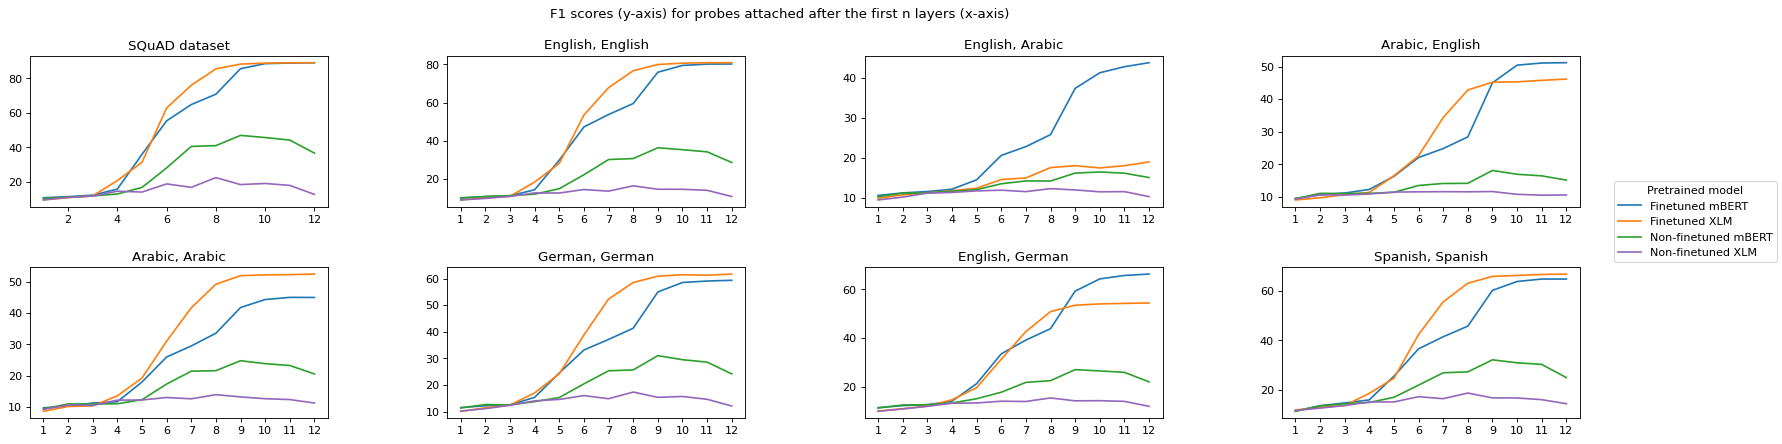

In [ ]:
#@title

language_indexes = [ 'mlqa_en_en', 'mlqa_en_ar', 'mlqa_ar_en', 'mlqa_ar_ar', 'mlqa_de_de', 'mlqa_en_de','mlqa_es_es']

language_texts = ["English, English", "English, Arabic", "Arabic, English", "Arabic, Arabic", "German, German", "English, German", "Spanish, Spanish"]

fig = plt.figure(figsize=(25, 6), dpi=80)
fig.subplots_adjust(hspace=0.4, wspace=0.4)

# SQUAD-plot
ax = fig.add_subplot(2, 4, 1)
ax.plot(list(range(1, 13)), get_squad_f1_by_layer(results_finetuned_mBERT), color = "tab:blue")
ax.plot(list(range(1, 13)), get_squad_f1_by_layer(results_finetuned_XLM), color = "tab:orange")
ax.plot(list(range(1, 13)), get_squad_f1_by_layer(results_non_finetuned_mBERT), color = "tab:green")
ax.plot(list(range(1, 13)), get_squad_f1_by_layer(results_non_finetuned_XLM), color = "tab:purple")
ax.set_title("SQuAD dataset")

# MLQA-plots
for i, language_index_pair in enumerate(language_indexes, 2):
  ax = fig.add_subplot(2, 4, i)
  ax.plot(list(range(1, 13)), get_mlqa_f1_by_layer(results_finetuned_mBERT, language_index_pair), color = "tab:blue")
  ax.plot(list(range(1, 13)), get_mlqa_f1_by_layer(results_finetuned_XLM, language_index_pair), color = "tab:orange")
  ax.plot(list(range(1, 13)), get_mlqa_f1_by_layer(results_non_finetuned_mBERT, language_index_pair), color = "tab:green")
  ax.plot(list(range(1, 13)), get_mlqa_f1_by_layer(results_non_finetuned_XLM, language_index_pair), color = "tab:purple")


  ax.set_title(language_texts[i-2])
  plt.xticks(range(1, 13))

fig.legend(ax,     # The line objects
           labels=["Finetuned mBERT", "Finetuned XLM", "Non-finetuned mBERT", "Non-finetuned XLM"],   # The labels for each line
           loc="center right",   # Position of legend
           title="Pretrained model"  # Title for the legend
           )

fig.suptitle("F1 scores (y-axis) for probes attached after the first n layers (x-axis)")

plt.show()

As results one gets:

**Non-finetuned models**:

- The non-finetuned models (where only the head is trained) do not perform well. Not much QA-knowledge is present in this model. When finetuning, it seems like the QA-abilities spread well across all layers and are not only fixed in the head. 
- Non-finetuned mBERT performs slightly better than non-finetuned XLM.

**Finetuned models**:

- Results on the SQuAD-evaluation dataset are the best, followed by *mlqa.en.en* results: these datasets correspond best to the training one.
- QA-abilities seem to be distributed very similarly across all languages, except for *en.ar*. Curves show the same behavior across all plots, indicating that there is no substantial difference in where the QA-abilities in one language or language-pair get picked up. --> They seem to be learned in a very parallel fashion and there is not necessarily a multilingual-ability picked up in one of the layers.
- **Finetuned XLM**: F1-curves over the layers are all sigmoid-shaped (except for *mlqa.en.ar*). Also there is always a point where this curve is over the mBERT-curve, implying that XLM picks up QA abilities earlier on in the layers.
- **Finetuned mBERT**: all the curves plateau at around layer 6 and make a big step in the F1-scores after layer 8. Layer 9 seems to be crucial as, when this one is added, the encodings seem to be much richer and the model head can pick up a lot on the QA-abilities

--> It seems that QA-abilities are mostly learned by the model between layers 4 and 9 for both models and learning seems language-independent: it occurs similarly in all layers and not a single layer is responsible for picking up the multilingual QA-abilities. 




## Comparing the F1 scores after the final layers evaluated on different multlingual combinations 

We can now look at the final F1 scores (after the final layers of the pretrained language model) for the finetuned and non-finetuned models. In read are always marked the monoligual QA-tasks, whilst the multilingual ones are in black.

### Finetuned models

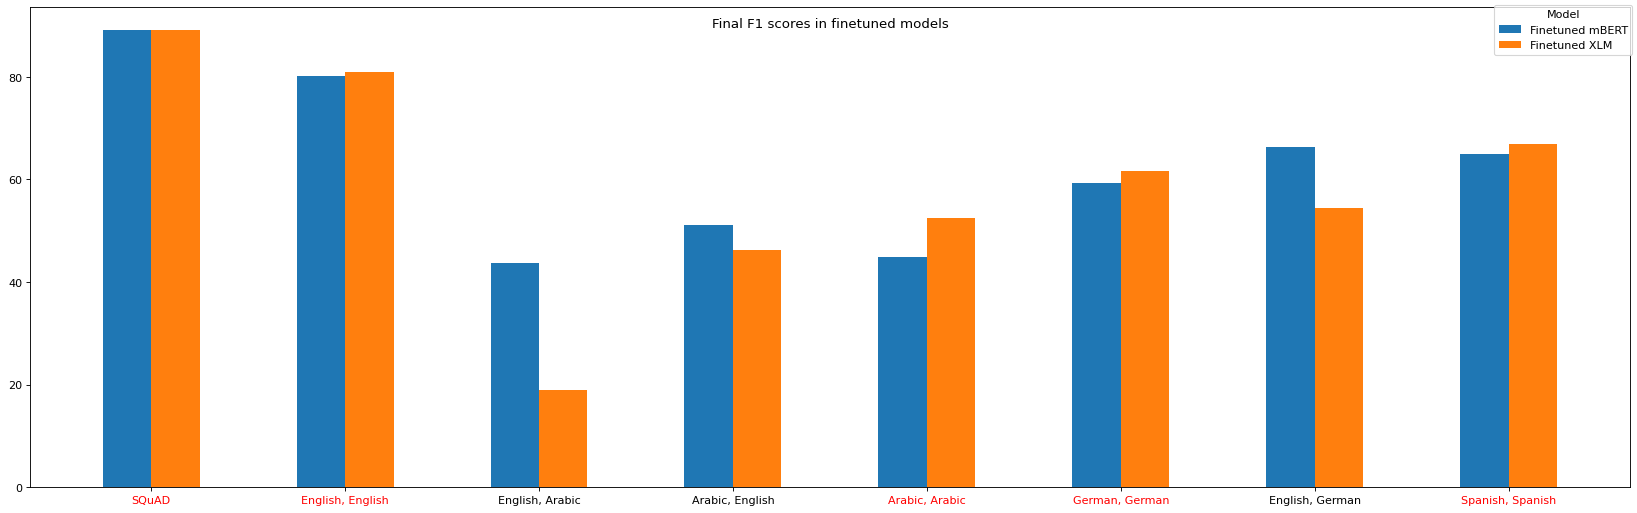

In [ ]:
#@title

language_indexes = [ 'mlqa_en_en', 'mlqa_en_ar', 'mlqa_ar_en', 'mlqa_ar_ar', 'mlqa_de_de', 'mlqa_en_de','mlqa_es_es']

language_texts = ["SQuAD", "English, English", "English, Arabic", "Arabic, English", "Arabic, Arabic", "German, German", "English, German", "Spanish, Spanish"]

max_f1_by_languages_XLM = []
max_f1_by_languages_mBERT = []

max_f1_by_languages_XLM.append(get_squad_f1_by_layer(results_finetuned_XLM)[-1])
max_f1_by_languages_mBERT.append(get_squad_f1_by_layer(results_finetuned_mBERT)[-1])

for language_index_pair in language_indexes:
  max_f1_by_languages_XLM.append(get_mlqa_f1_by_layer(results_finetuned_XLM, language_index_pair)[-1])
  max_f1_by_languages_mBERT.append(get_mlqa_f1_by_layer(results_finetuned_mBERT, language_index_pair)[-1])


X = np.arange(8)
fig = plt.figure(figsize=(20, 6), dpi=80)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, max_f1_by_languages_mBERT, width = 0.25)
ax.bar(X + 0.25, max_f1_by_languages_XLM, width = 0.25)

plt.xticks(X + 0.25/2, language_texts)

fig.legend(ax,     # The line objects
           labels=["Finetuned mBERT", "Finetuned XLM"],   # The labels for each line
           loc="best",   # Position of legend
           title="Model"  # Title for the legend
           )

for i in [0, 1, 4, 5, 7]:
  plt.gca().get_xticklabels()[i].set_color('red') 

fig.suptitle("Final F1 scores in finetuned models")

plt.show()

Results:
- mBERT performs surprisingly better in the cross-lingual case, whilst XLM is better in the monolingual one (in red), although not by a lot. 
- English, Arabic is a bit of an outlier. mBERT performs a lot better there and this is also the only combination where the learning seems different above.
- The scores are generally very similar.

### Non finetuned (only pretrained) models

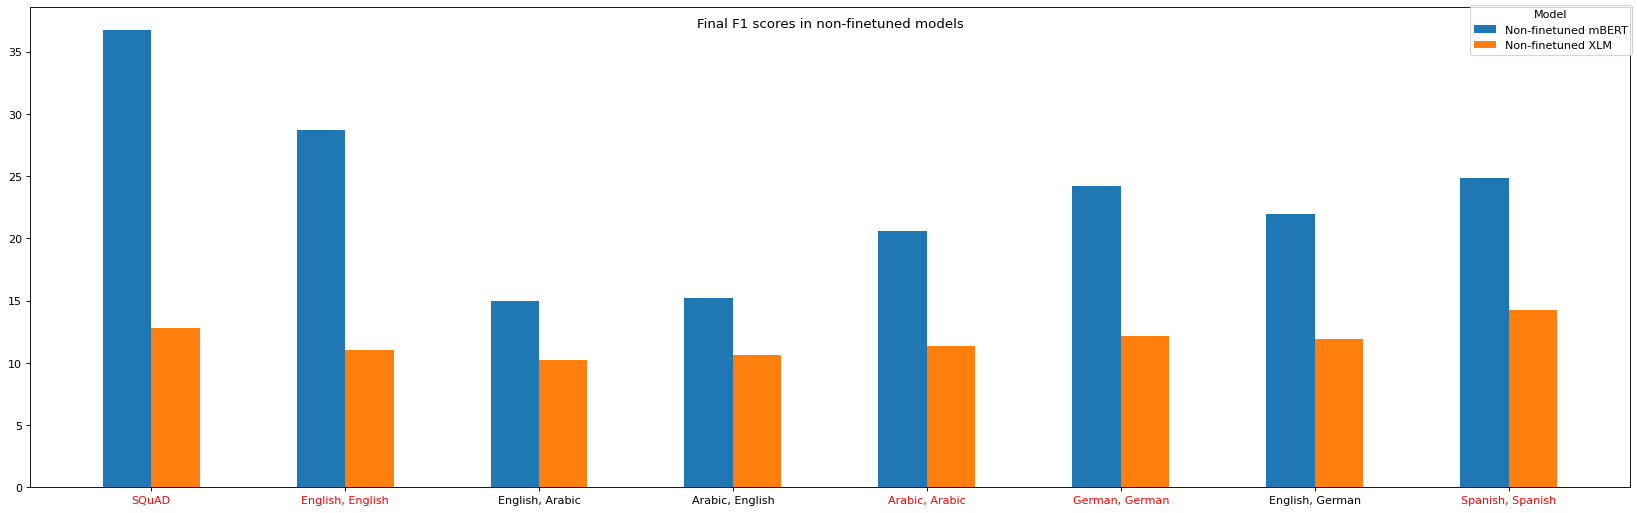

In [ ]:
#@title

language_indexes = [ 'mlqa_en_en', 'mlqa_en_ar', 'mlqa_ar_en', 'mlqa_ar_ar', 'mlqa_de_de', 'mlqa_en_de','mlqa_es_es']

language_texts = ["SQuAD", "English, English", "English, Arabic", "Arabic, English", "Arabic, Arabic", "German, German", "English, German", "Spanish, Spanish"]

final_f1_by_languages_non_finetuned_XLM = []
final_f1_by_languages_non_finetuned_mBERT = []

final_f1_by_languages_non_finetuned_XLM.append(get_squad_f1_by_layer(results_non_finetuned_XLM)[-1])
final_f1_by_languages_non_finetuned_mBERT.append(get_squad_f1_by_layer(results_non_finetuned_mBERT)[-1])

for language_index_pair in language_indexes:
  final_f1_by_languages_non_finetuned_XLM.append(get_mlqa_f1_by_layer(results_non_finetuned_XLM, language_index_pair)[-1])
  final_f1_by_languages_non_finetuned_mBERT.append(get_mlqa_f1_by_layer(results_non_finetuned_mBERT, language_index_pair)[-1])


X = np.arange(8)
fig = plt.figure(figsize=(20, 6), dpi=80)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, final_f1_by_languages_non_finetuned_mBERT, width = 0.25)
ax.bar(X + 0.25, final_f1_by_languages_non_finetuned_XLM, width = 0.25)

plt.xticks(X + 0.25/2, language_texts)

fig.legend(ax,     # The line objects
           labels=["Non-finetuned mBERT", "Non-finetuned XLM"],   # The labels for each line
           loc="best",   # Position of legend
           title="Model"  # Title for the legend
           )

for i in [0, 1, 4, 5, 7]:
  plt.gca().get_xticklabels()[i].set_color('red') 

fig.suptitle("Final F1 scores in non-finetuned models")

plt.show()

Results: 
- The F1-scores are really low. mBERT performs a lot better here across all languages.
- It seems again like there is not a lot of QA-knowledge in the encodings generated by the non-finetuned models.

## Comparing the final F1 score for a full model finetuned across all layers or only layers 4-8

QA-abilities seem to be very concentrated on only a few of the middle layers (4-9 for mBERT and 4-8 for XLM): adding each one of those layers adds a lot of performance as one can see in the first plot. So one can also just finetune those layers together with the model-head. Below the reader can find the results comparing such a model where we finetune only layers 4-8 of XLM-RoBERTa-base and the model head, with one where we finetune all the layers of XLM-RoBERTa-base.

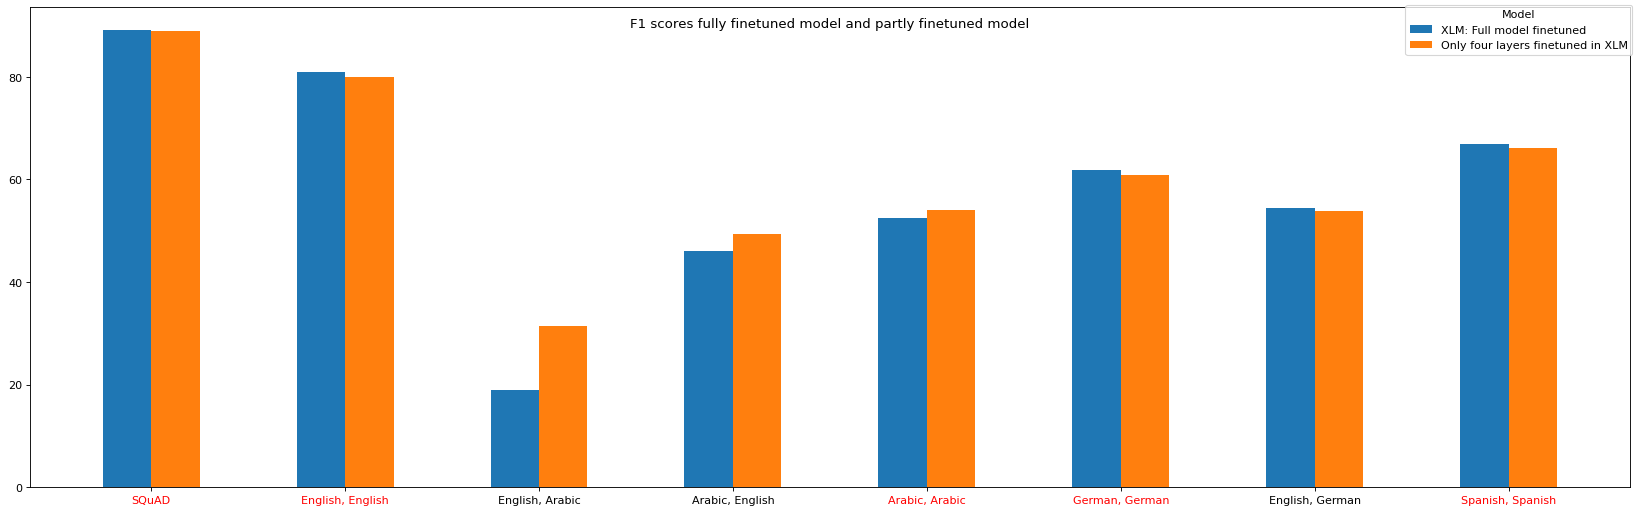

In [ ]:
#@title

language_indexes = [ 'mlqa_en_en', 'mlqa_en_ar', 'mlqa_ar_en', 'mlqa_ar_ar', 'mlqa_de_de', 'mlqa_en_de','mlqa_es_es']

results_texts = ["SQuAD", "English, English", "English, Arabic", "Arabic, English", "Arabic, Arabic", "German, German", "English, German", "Spanish, Spanish"]

finetuned_full_model_f1 = []
finetuned_4_layers_f1 = []

finetuned_full_model_f1.append(results_no_layers_freezed_XLM["squad"]["all results"]["f1"])
finetuned_4_layers_f1.append(results_4_layers_freezed_XLM["squad"]["all results"]["f1"])

for language_index_pair in language_indexes:
  finetuned_full_model_f1.append(results_no_layers_freezed_XLM["mlqa"][language_index_pair]["all results"]["f1"])
  finetuned_4_layers_f1.append(results_4_layers_freezed_XLM["mlqa"][language_index_pair]["all results"]["f1"])


X = np.arange(8)
fig = plt.figure(figsize=(20, 6), dpi=80)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, finetuned_full_model_f1, width = 0.25)
ax.bar(X + 0.25, finetuned_4_layers_f1, width = 0.25)

plt.xticks(X + 0.25/2, results_texts)

fig.legend(ax,     # The line objects
           labels=["XLM: Full model finetuned ", "Only four layers finetuned in XLM"],   # The labels for each line
           loc="best",   # Position of legend
           title="Model"  # Title for the legend
           )

for i in [0, 1, 4, 5, 7]:
  plt.gca().get_xticklabels()[i].set_color('red') 

fig.suptitle("F1 scores fully finetuned model and partly finetuned model")

plt.show()

Results:

- The performance across all languages of the only partly finetuned model is extremely similar to the fully finetuned one. 
- In for XLM-RoBERTa-base difficult language: Arabic the results are even better by a lot, when finetuning only a part of the model (especially in the combination English, Arabic).
- This is in contrast with some of the literature suggesting generally that finetuning only the later layers is useful, whilst we here finetune only the middle ones. 

Finetuning only layers 4-8 yields massive improvements in training time:



Training only layer 4-8 and the model head cuts down training time by 60.32484857954825% 



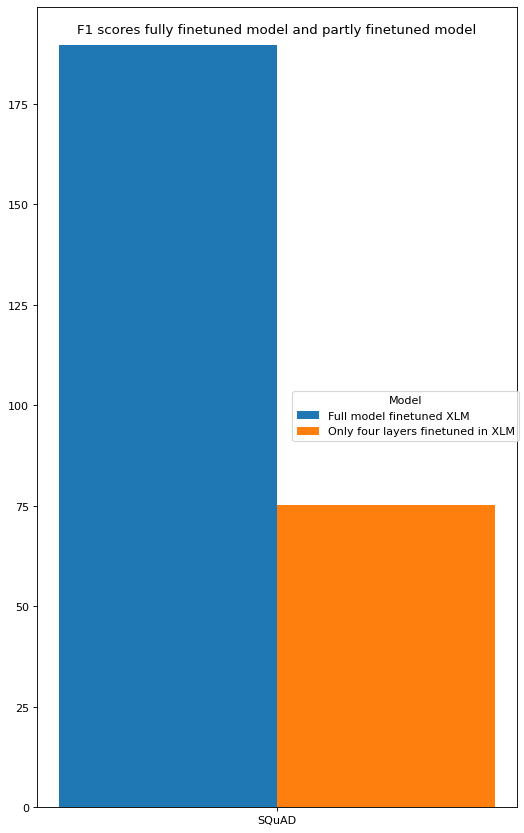

In [ ]:
#@title

X = np.arange(1)
fig = plt.figure(figsize=(6, 10), dpi=80)
ax = fig.add_axes([0,0,1,1])
ax.bar(X + 0.00, [results_no_layers_freezed_XLM["squad"]["all results"]["train_runtime"]/60], width = 0.25)
ax.bar(X + 0.25, results_4_layers_freezed_XLM["squad"]["all results"]["train_runtime"]/60, width = 0.25)

plt.xticks(X + 0.25/2, results_texts)

fig.legend(ax,     # The line objects
           labels=["Full model finetuned XLM", "Only four layers finetuned in XLM"],   # The labels for each line
           loc="right",   # Position of legend
           title="Model"  # Title for the legend
           )


fig.suptitle("Training time for fully finetuned model and partly finetuned model")

pct_cut_down = 1-results_4_layers_freezed_XLM["squad"]["all results"]["train_runtime"]/results_no_layers_freezed_XLM["squad"]["all results"]["train_runtime"]

print("Training only layer 4-8 and the model head cuts down training time by " + str(100*pct_cut_down) + "% \n")
plt.show()

## Tables recording our findings

For the reader to explore the findings, the authors prepared some tables showcasing the results:

In [ ]:
#@title

language_indexes = [ 'mlqa_en_en', 'mlqa_en_ar', 'mlqa_ar_en', 'mlqa_ar_ar', 'mlqa_de_de', 'mlqa_en_de','mlqa_es_es']

language_texts = ["SQuAD", "English, English", "English, Arabic", "Arabic, English", "Arabic, Arabic", "German, German", "English, German", "Spanish, Spanish"]

# Function to create tables
def score_table(results_f1_dictionary, language_indexes, language_pairs):
  f1_scores = []
  # Get squad f1
  f1_scores.append(get_squad_f1_by_layer(results_f1_dictionary))
  # Get mlqa f1 for all languages
  for i, language_index_pair in enumerate(language_indexes, 2):  
    f1_scores.append(get_mlqa_f1_by_layer(results_f1_dictionary, language_index_pair))
  df = pd.DataFrame(f1_scores).T
  df.columns = language_texts
  df.index += 1
  df.index.name = 'Layers'
  df = df.round(2)
  return df

pretrained_mBERT_table = score_table(results_non_finetuned_mBERT, language_indexes, language_texts)
finetuned_mBERT_table = score_table(results_finetuned_mBERT, language_indexes, language_texts)
pretrained_XLM_table = score_table(results_non_finetuned_XLM, language_indexes, language_texts)
finetuned_XLM_table = score_table(results_finetuned_XLM, language_indexes, language_texts)

In [ ]:
%load_ext google.colab.data_table
#@title {run: 'auto'}
table_name = "pretrained_mBERT_table" #@param ["pretrained_mBERT_table", "finetuned_mBERT_table", "pretrained_XLM_table", "finetuned_XLM_table"]
tables = globals()[table_name]
tables

The google.colab.data_table extension is already loaded. To reload it, use:
  %reload_ext google.colab.data_table


,SQuAD,"English, English","English, Arabic","Arabic, English","Arabic, Arabic","German, German","English, German","Spanish, Spanish"
Layers,,,,,,,,
1,10.50,10.10,10.21,9.45,9.45,11.40,11.17,11.14
2,11.26,10.98,11.07,11.10,11.05,12.68,12.40,13.33
3,11.94,11.43,11.16,11.08,11.00,12.57,12.54,14.22
4,13.09,12.18,11.58,11.10,11.10,13.78,13.23,14.76
5,16.86,15.06,11.97,11.43,12.39,15.32,14.99,16.86
6,28.18,22.33,13.44,13.53,17.37,20.46,17.68,21.81
7,40.61,30.28,14.15,14.13,21.47,25.37,21.72,26.83
8,41.08,30.78,14.13,14.18,21.63,25.70,22.43,27.21
9,47.00,36.43,16.12,18.13,24.80,31.07,26.97,32.10


# Resources


Here are some additional resources for the interested readers:

- The [main paper](https://github.com/jakobwes/QA_layer_freeze/blob/main/report.pdf)
- The [GitHub-repo](https://github.com/jakobwes/QA_layer_freeze) containing the code and the result-data.
- The [Guide to the code](https://github.com/jakobwes/QA_layer_freeze/blob/main/experiment_code/Guide%20to%20the%20code.md) for anyone interested in reproducing the results.
- The amazing computational resources in [Google Colab](colab.research.google.com/), that allowed the authors to make experiments and the incredible [Huggingface-libraries](https://huggingface.co/).